In [0]:
!pip install textsearch
!pip install contractions

     |████████████████████████████████| 317kB 3.3MB/s 
     |████████████████████████████████| 245kB 14.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81706 sha256=dffb88c001663ffc7f9be6b60ed16552e22816e8c661aa7ffc310a9bde0b7363
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import re
from bs4 import BeautifulSoup
import unicodedata
import contractions
import spacy
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

nltk.download('punkt')
nltk.download('stopwords')
sns.set_style("darkgrid")
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
news_articles = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Covid 19 Articles/new_articles.csv')
news_articles.shape

(4533, 9)

In [0]:
nlp = spacy.load('en', parse=False, tag=False, entity=False)
ps = nltk.porter.PorterStemmer()

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def expand_contractions(text):
    return contractions.fix(text)


def spacy_lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


def simple_stemming(text, stemmer=ps):
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text


def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
  

In [0]:
def text_pre_processor(text, html_strip=True, accented_char_removal=True, contraction_expansion=True,
                       text_lower_case=True, special_char_removal=True, remove_digits=True, stopword_removal=True, 
                       stopword_list=None):
    
    # strip HTML
    if html_strip:
        text = strip_html_tags(text)
    
    # remove extra newlines (often might be present in really noisy text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    
    # remove accented characters
    if accented_char_removal:
        text = remove_accented_chars(text)
    
    # expand contractions    
    if contraction_expansion:
        text = expand_contractions(text)
      
    # remove special characters and\or digits    
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        text = special_char_pattern.sub(" \\1 ", text)
        text = remove_special_characters(text, remove_digits=remove_digits)
         
    # lowercase the text    
    if text_lower_case:
        text = text.lower()
        
    # remove stopwords
    if stopword_removal:
        text = remove_stopwords(text, is_lower_case=text_lower_case, 
                                stopwords=stopword_list)
    
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9_\s]*com[a-zA-Z0-9_\s]*', '', text)
    
    # remove extra whitespace
    text = re.sub(' +', ' ', text)
    text = text.strip()
    
    return text

In [0]:
news_articles.dropna(subset=['title', 'description'], inplace=True, axis=0)
news_articles['content'].fillna('missing', inplace=True)

news_articles['title'] = news_articles['title'].apply(text_pre_processor)
news_articles['description'] = news_articles['description'].apply(text_pre_processor)
news_articles['content'] = news_articles['content'].apply(text_pre_processor)


In [0]:
def textblob_sentiment(title, description):
    blob = TextBlob(f"{title} {description}")
    return blob.sentiment.polarity

In [0]:
news_articles['story_sentiment'] = news_articles.apply(lambda x: textblob_sentiment(x['title'], x['description']), 
                                                       axis=1)
sent_df = news_articles.groupby('source').aggregate({'story_sentiment':np.mean,'index':'count'}).reset_index().sort_values('story_sentiment')
relevant_sent_df = sent_df[sent_df['index']>10]

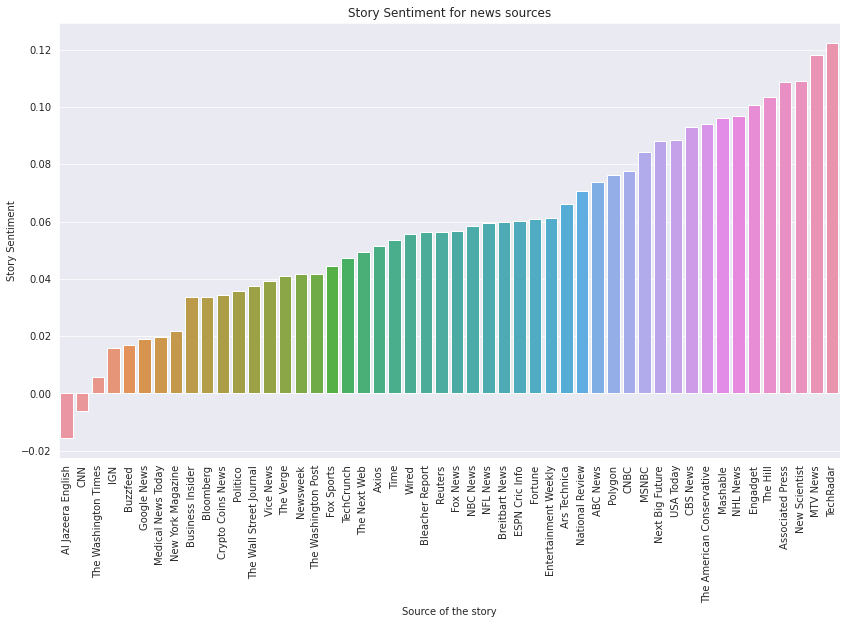

In [0]:
plt.figure(figsize=(14,8))
chart = sns.barplot(x='source', y='story_sentiment', data=relevant_sent_df)
plt.xlabel('Source of the story')
plt.ylabel('Story Sentiment')
plt.title('Story Sentiment for news sources')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

In [0]:
popular_news_sources = ['CNN', 'The Wall Street Journal', 'Fox News', 'Associated Press', 'NBC News', 'CNBC', 
                        'Al Jazeera English', 'The Washington Post']
news_articles['story'] = news_articles['title'] + news_articles['description'] + news_articles['content']
popular_news_source_articles = news_articles[news_articles['source'].isin(popular_news_sources)]

popular_news_source_articles["num_words"] = popular_news_source_articles["story"].apply(lambda x: len(str(x).split()))
popular_news_source_articles["num_unique_words"] = popular_news_source_articles["story"].apply(lambda x: len(set(str(x).split())))

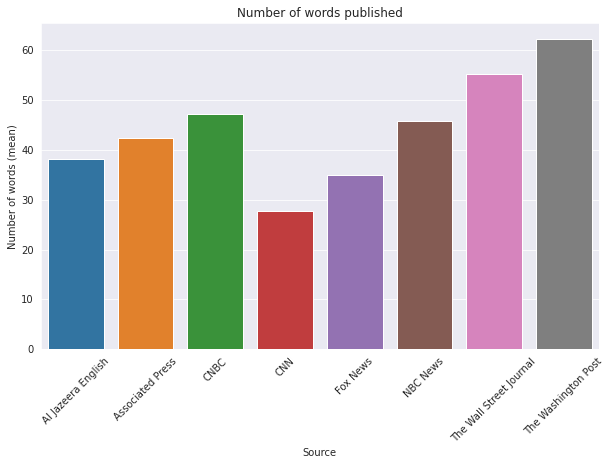

In [0]:
words_df = popular_news_source_articles.groupby(['source'])['num_words'].mean().reset_index()
plt.figure(figsize=(10,6))
chart = sns.barplot(x='source', y='num_words', data=words_df)
plt.xlabel('Source')
plt.ylabel('Number of words (mean)')
plt.title('Number of words published')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

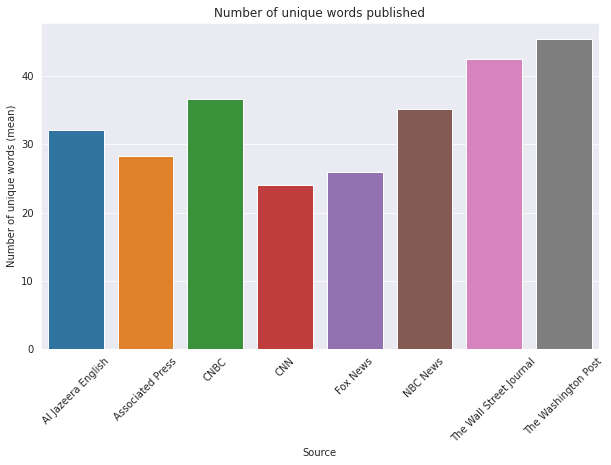

In [0]:
uq_words_df = popular_news_source_articles.groupby(['source'])['num_unique_words'].mean().reset_index()
plt.figure(figsize=(10,6))
chart = sns.barplot(x='source', y='num_unique_words', data=uq_words_df)
plt.xlabel('Source')
plt.ylabel('Number of unique words (mean)')
plt.title('Number of unique words published')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [0]:
stopwords = set(STOPWORDS)
stopwords.add('coronavirus')
stopwords.add('covid-19')
stopwords.add('covid19')

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

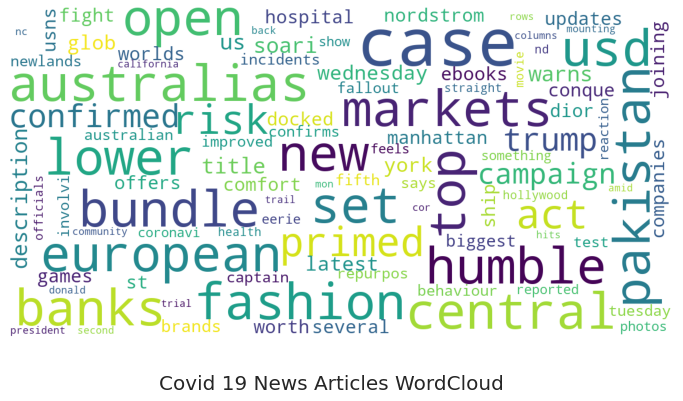

In [0]:
show_wordcloud(news_articles[['title', 'description']], title='Covid 19 News Articles WordCloud')

In [0]:
def get_words(story):
    return story.split(" ")

words = news_articles["story"].apply(get_words)
model = Word2Vec(words, size=100, window=2, min_count=5, workers=4)

In [0]:
model.most_similar('coronavirus')[:5]

[('covid', 0.9840246438980103),
 ('outbreak', 0.959703803062439),
 ('spread', 0.9592019319534302),
 ('novel', 0.9585954546928406),
 ('caused', 0.9573068618774414)]

In [0]:
def tsne_scatterplot(model, word):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word
    and its list of most similar words
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

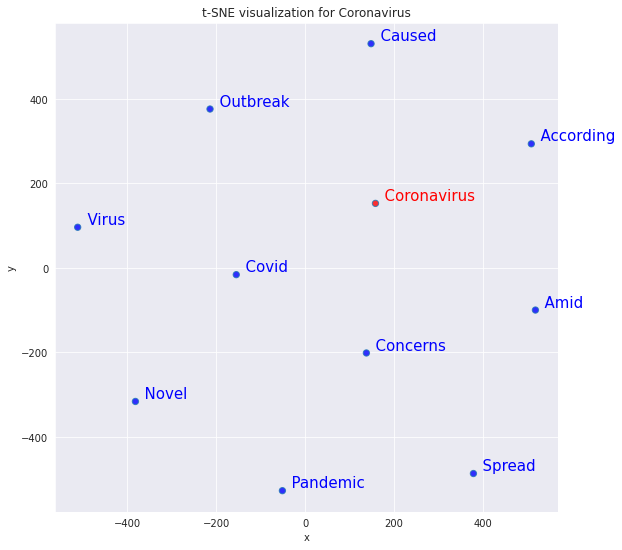

In [0]:
tsne_scatterplot(model, 'coronavirus')

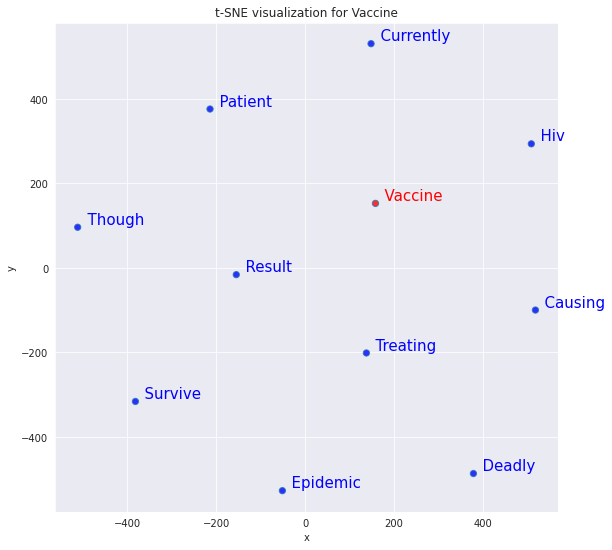

In [0]:
tsne_scatterplot(model, 'vaccine')